# Structural comparison of manipulated O1v5-SONATA connectomes
This is an auxiliary notebook for analysing manipulated O1v5-SONATA connectomes, which

 - sets up structural comparator
 - runs structural comparisom

<u>Requirements</u>: [connectome-manipulator](https://bbpgitlab.epfl.ch/conn/structural/connectome_manipulator) package (v0.0.10.dev1 or later; with v4 config format and `parallel-manipulator` entry point)

ℹ️ Related ticket: [[ACCS-19](https://bbpteam.epfl.ch/project/issues/browse/ACCS-19)] "Rewiring V5 to test reliability results"


In [1]:
# Initialization

""" Global imports """
import json
import os

""" Local imports """
from connectome_manipulator.connectome_comparison import structural_comparator

In [13]:
def default_structcomp_config(output_path, base_name, circuit_specs):
    """Generates a default structural comparator config dict w/o any specific comparison."""
    assert isinstance(circuit_specs, list) and len(circuit_specs) == 2, 'ERROR: Two circuits required for comparison!'

    structcomp_config = {}
    structcomp_config['working_dir'] = os.path.join(output_path, base_name)
    structcomp_config['out_dir'] = structcomp_config['working_dir']
    structcomp_config['circuits'] = {str(i): {'circuit_config': circuit_specs[i]['config'],
                                              'circuit_name': circuit_specs[i]['name']} for i in range(2)}
    structcomp_config['plot_types'] = []

    return structcomp_config

def upper_first(name):
    return name[0].upper() + name[1:]

def add_ConnProb_to_config(structcomp_config, hyper_column, group_by, syn_class='EXC', skip_empty_groups=False):
    """Adds "connection probability per layer" comparison to structural comparator config."""
    assert 'plot_types' in structcomp_config, 'ERROR: Plot types missing!'
    if syn_class is None:
        cl_name = ''
        cl_sel = {}
    else:
        assert syn_class in ['EXC', 'INH'], 'ERROR: Synapse class error!'
        cl_name = syn_class[0].upper() * 2
        cl_sel = {'synapse_class': syn_class}  # Same synapse class for pre/post selection
    if hyper_column is None:
        assert group_by in ['layer', 'mtype', 'hypercolumn'], f'ERROR: Grouping by "{group_by}" not supported!'
        if len(cl_name) > 0:
            cl_name = '_' + cl_name
        name = f'ConnPer{upper_first(group_by)}{cl_name}'
        mc_sel = {}
    else:
        assert 0 <= hyper_column <= 6, 'ERROR: Hyper column out of range!'
        assert group_by in ['layer', 'mtype'], f'ERROR: Grouping by "{group_by}" not supported!'
        name = f'ConnPer{upper_first(group_by)}_mc{hyper_column}{cl_name}'
        mc_sel = {'hypercolumn': hyper_column}
    comp_dict = {'name': name,
                 'fct': {'source': 'connectivity',
                         'kwargs': {'group_by': group_by,
                                    'skip_empty_groups': skip_empty_groups,
                                    'sel_src': {**mc_sel, **cl_sel},
                                    'sel_dest': {**mc_sel, **cl_sel}}},
                         'res_sel': ['nsyn_conn', 'conn_prob'],
                         'range_prctile': 100,
                         'fig_size': (11, 3),
                         'fig_file': {'format': 'png', 'dpi': 600}}
    structcomp_config['plot_types'].append(comp_dict)

def add_MeanProps_to_config(structcomp_config, hyper_column, props_list, group_by, skip_empty_groups=False):
    """Adds "connection properties (mean) per layer" comparison to structural comparator config."""
    assert 'plot_types' in structcomp_config, 'ERROR: Plot types missing!'
    assert 0 <= hyper_column <= 6, 'ERROR: Hyper column out of range!'
    assert isinstance(props_list, list) and len(props_list) > 0, "ERROR: Non-empty list of properties required!"
    assert group_by in ['layer', 'mtype'], f'ERROR: Grouping by "{group_by}" not supported!'
    comp_dict = {'name': f'PropsPer{upper_first(group_by)}_mc{hyper_column}EE',
                         'fct': {'source': 'properties',
                                 'kwargs': {'group_by': group_by,
                                            'skip_empty_groups': skip_empty_groups,
                                            'sel_src': {'hypercolumn': hyper_column, 'synapse_class': 'EXC'},
                                            'sel_dest': {'hypercolumn': hyper_column, 'synapse_class': 'EXC'},
                                            'fct': 'np.mean'}},
                                 'res_sel': props_list,
                                 'range_prctile': 100,
                                 'fig_size': (11, 3),
                                 'fig_file': {'format': 'png', 'dpi': 600}}
    structcomp_config['plot_types'].append(comp_dict)

def add_AdjMat_to_config(structcomp_config, hyper_column):
    """Adds "adjacency matrix" comparison to structural comparator config."""
    assert 'plot_types' in structcomp_config, 'ERROR: Plot types missing!'
    assert 0 <= hyper_column <= 6, 'ERROR: Hyper column out of range!'
    comp_dict = {'name': f'Adjacency_mc{hyper_column}EE',
                         'fct': {'source': 'adjacency',
                                 'kwargs': {'sel_src': {'hypercolumn': hyper_column, 'synapse_class': 'EXC'},
                                            'sel_dest': {'hypercolumn': hyper_column, 'synapse_class': 'EXC'}}},
                                 'res_sel': ['adj', 'adj_cnt'],
                                 'range_prctile': 95,
                                 'fig_size': (11, 3),
                                 'fig_file': {'format': 'png', 'dpi': 600}}
    structcomp_config['plot_types'].append(comp_dict)

def export_structcomp_config(structcomp_config, config_path):
    """Writes structural comparator config to .json config file(s)."""
    if not isinstance(config_path, list):
        config_path = [config_path]

    base_name = os.path.split(structcomp_config['working_dir'])[-1]
    fn = f'structcomp_config__{base_name}__{structcomp_config["circuits"]["0"]["circuit_name"]}_vs_{structcomp_config["circuits"]["1"]["circuit_name"]}.json'
    for cpath in config_path:
        with open(os.path.join(cpath, fn), 'w') as f:
            json.dump(structcomp_config, f, indent=2)
        print(f"Config file {fn} written to {cpath}")

def print_launch_cmd(config_path, config_fn, force_recomp=False):
    if force_recomp:
        run_cmd = f"sbatch run_struct_comparison.sh {config_fn} --force-recomp-circ1 --force-recomp-circ2"
    else:
        run_cmd = f"sbatch run_struct_comparison.sh {config_fn}"
    print(f"# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:")
    print(f"cd {config_path}")
    print(run_cmd)

def load_config_from_file(path, fn):
    config_file = os.path.join(path, fn)
    with open(config_file, 'r') as f:
        structcomp_config = json.load(f)
    return structcomp_config

### Selection of circuits to compare

In [3]:
# Circuit base name
circuit_name_base = 'O1v5-SONATA'

# Original circuit
circuit_name_orig = 'Orig'
circuit_config_orig = f'/gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/{circuit_name_base}/sonata/circuit_config_tmp.json' # SONATA config (.json)  # TEMP edges file with afferent_center_x/y/z properties preliminarily added w/o validation, see [NSETM-1222]
circuit_spec_orig = {'name': circuit_name_orig, 'config': circuit_config_orig}

# Manipulated circuits
enhance_N = [100, 200, 300, 400, 500, 670]
circuit_names_manip = [f'Enhanced{_n}K' for _n in enhance_N]
circuit_configs_manip = [f'/gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/{circuit_name_base}__ConnRewireEnhanced{_n}Kmc2EE/circuit_config.json' for _n in enhance_N]
circuit_specs_manip = [{'name': nm, 'config': cfg} for nm, cfg in zip(circuit_names_manip, circuit_configs_manip)]

### Configuration of structural comparison

In [4]:
# Output paths
output_path = '/gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison'
config_paths = ['../configs', '/gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/configs']  # Write to local and proj9 folder

# Selection of column
hyper_column = 2  # 2...central column

# Selection of properties to compare
# props_list = ['conductance', 'decay_time', 'delay', 'depression_time', 'facilitation_time', 'syn_type_id', 'u_syn']

In [6]:
# Structural comparison of original vs. simplified connectomes
for idx in range(len(enhance_N)):
    structcomp_config = default_structcomp_config(output_path, circuit_name_base, [circuit_spec_orig, circuit_specs_manip[idx]])
    add_ConnProb_to_config(structcomp_config, hyper_column, group_by='layer', skip_empty_groups=False)
    add_ConnProb_to_config(structcomp_config, hyper_column, group_by='mtype', skip_empty_groups=True)
#     add_MeanProps_to_config(structcomp_config, hyper_column, props_list=props_list, group_by='layer', skip_empty_groups=False)
#     add_MeanProps_to_config(structcomp_config, hyper_column, props_list=props_list, group_by='mtype', skip_empty_groups=True)
#     add_AdjMat_to_config(structcomp_config, hyper_column)
    export_structcomp_config(structcomp_config, config_paths)

Config file structcomp_config__O1v5-SONATA__Orig_vs_Enhanced100K.json written to ../configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Enhanced100K.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Enhanced200K.json written to ../configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Enhanced200K.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Enhanced300K.json written to ../configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Enhanced300K.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Enhanced400K.json written to ../configs
Config file structcomp_config__O1v5-SONATA__Orig_vs_Enhanced400K.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_c

### Run structural comparison

Launch using `sbatch` first, in order to extract/compute the results:

In [12]:
for _n in enhance_N:
    print_launch_cmd(config_paths[1], f'structcomp_config__{circuit_name_base}__Orig_vs_Enhanced{_n}K.json', force_recomp=False)
    print()
    if _n == enhance_N[0]:
        print('WAIT UNTIL "ORIG" RESULTS ARE READY BEFORE LAUNCHING THE OTHERS!')
        print()

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/configs
sbatch run_struct_comparison.sh structcomp_config__O1v5-SONATA__Orig_vs_Enhanced100K.json

WAIT UNTIL "ORIG" RESULTS ARE READY BEFORE LAUNCHING THE OTHERS!

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/configs
sbatch run_struct_comparison.sh structcomp_config__O1v5-SONATA__Orig_vs_Enhanced200K.json

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/configs
sbatch run_struct_comparison.sh structcomp_config__O1v5-SONATA__Orig_vs_Enhanced300K.json

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/configs
sbatch run_struct_comparison.sh structcomp_config__O1v5-SONATA__Orig_vs_Enhanced400K.json

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd /gpfs/b

Then, re-run directly within notebook w/o re-computing, incl. figure plotting:

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireEnhanced100Kmc2EE/circuit_config.json
INFO: Preparing "ConnPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerLayer_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced100K_ConnPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced100K/struct_comp-ConnPerLayer_mc2EE-nsyn_conn.png...


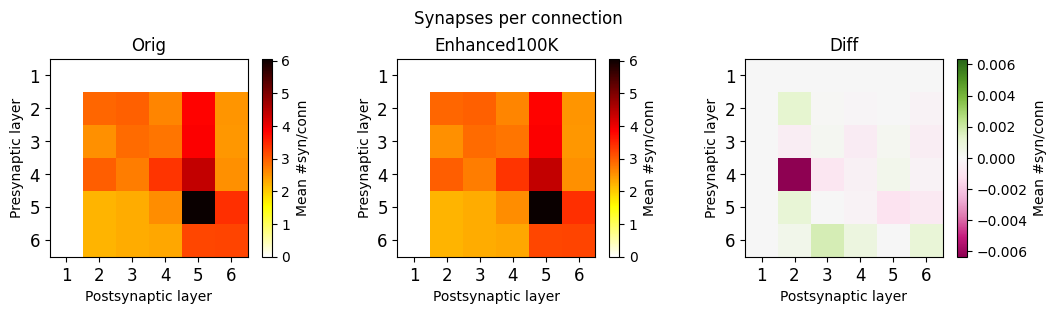

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced100K/struct_comp-ConnPerLayer_mc2EE-conn_prob.png...


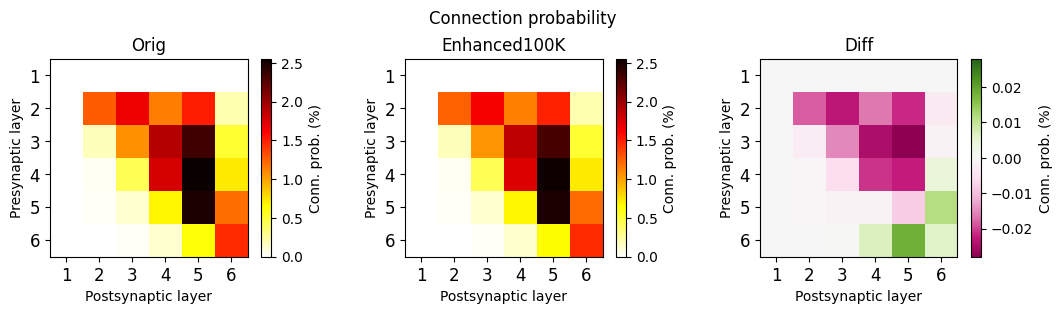

INFO: Preparing "ConnPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerMtype_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced100K_ConnPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced100K/struct_comp-ConnPerMtype_mc2EE-nsyn_conn.png...


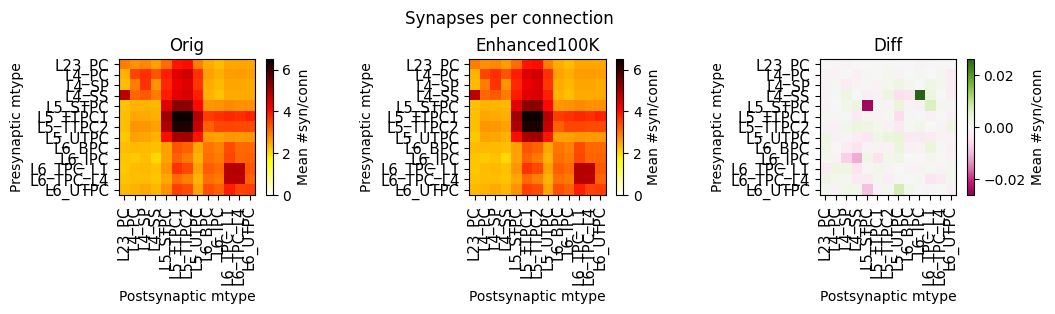

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced100K/struct_comp-ConnPerMtype_mc2EE-conn_prob.png...


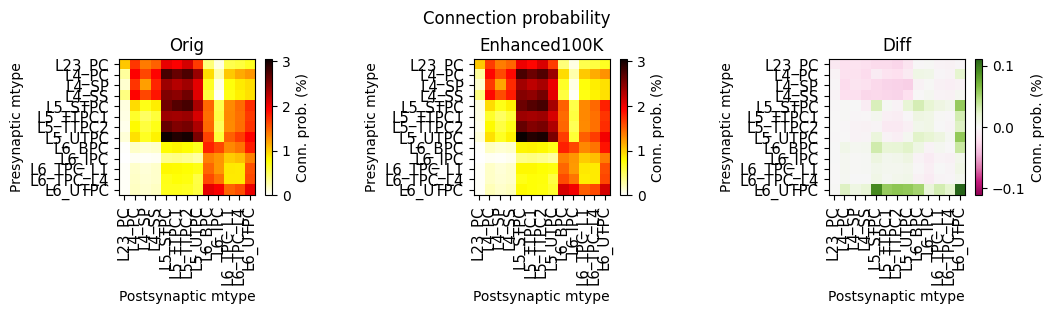

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireEnhanced200Kmc2EE/circuit_config.json
INFO: Preparing "ConnPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerLayer_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced200K_ConnPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced200K/struct_comp-ConnPerLayer_mc2EE-nsyn_conn.png...


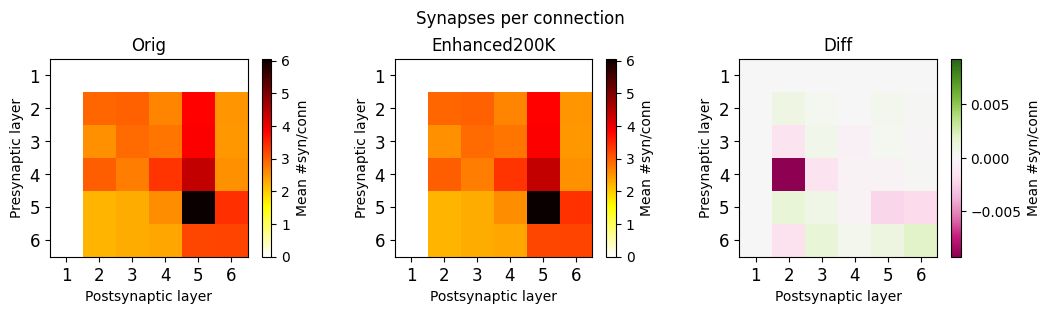

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced200K/struct_comp-ConnPerLayer_mc2EE-conn_prob.png...


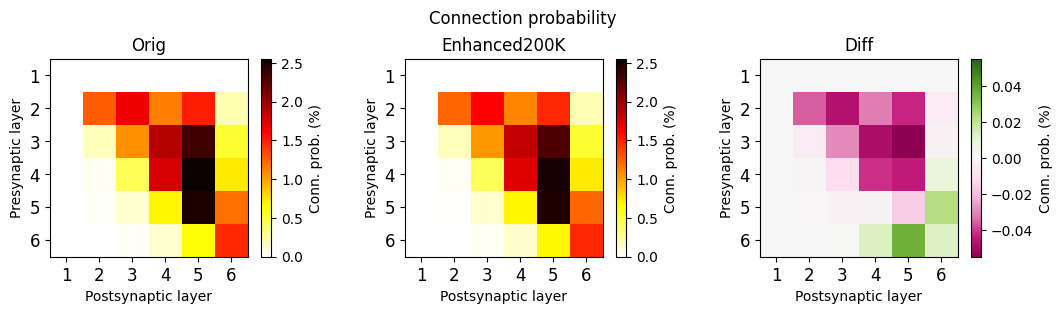

INFO: Preparing "ConnPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerMtype_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced200K_ConnPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced200K/struct_comp-ConnPerMtype_mc2EE-nsyn_conn.png...


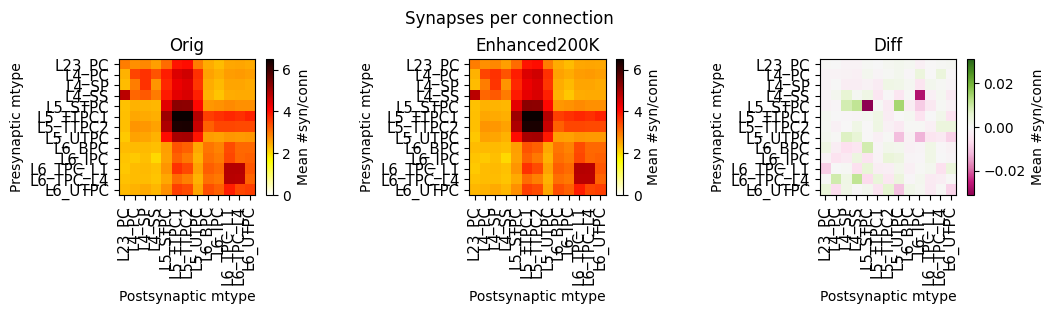

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced200K/struct_comp-ConnPerMtype_mc2EE-conn_prob.png...


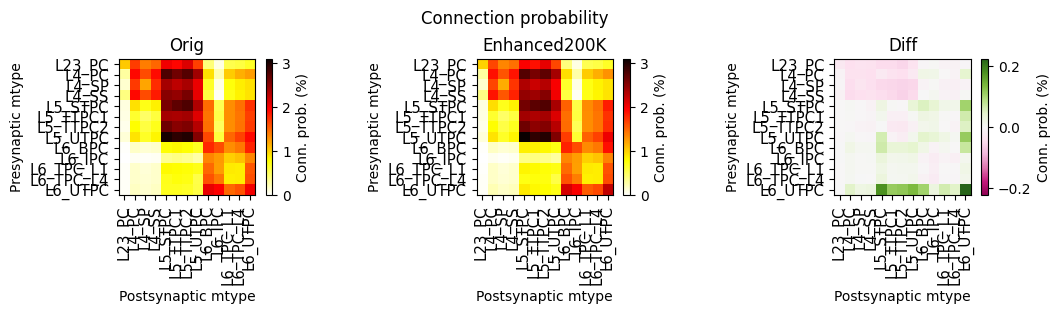

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireEnhanced300Kmc2EE/circuit_config.json
INFO: Preparing "ConnPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerLayer_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced300K_ConnPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced300K/struct_comp-ConnPerLayer_mc2EE-nsyn_conn.png...


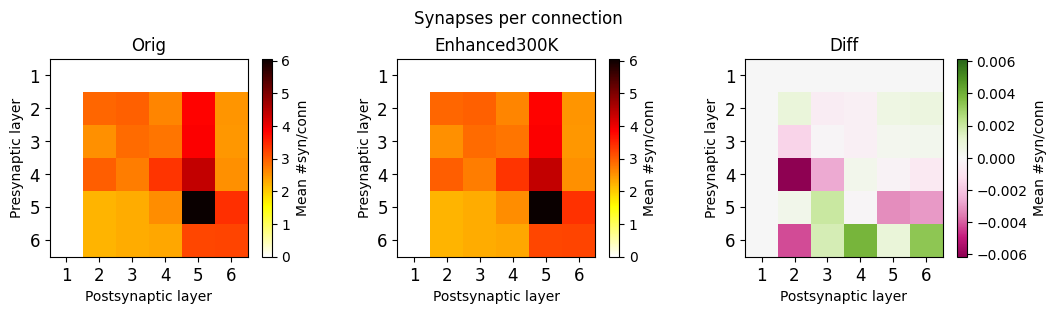

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced300K/struct_comp-ConnPerLayer_mc2EE-conn_prob.png...


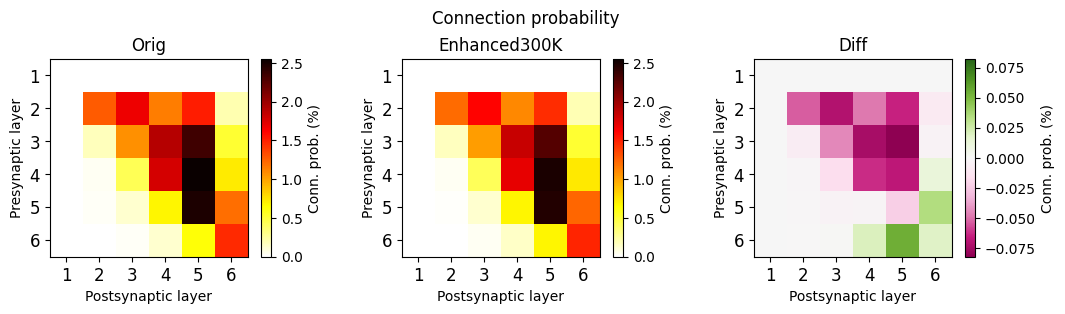

INFO: Preparing "ConnPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerMtype_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced300K_ConnPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced300K/struct_comp-ConnPerMtype_mc2EE-nsyn_conn.png...


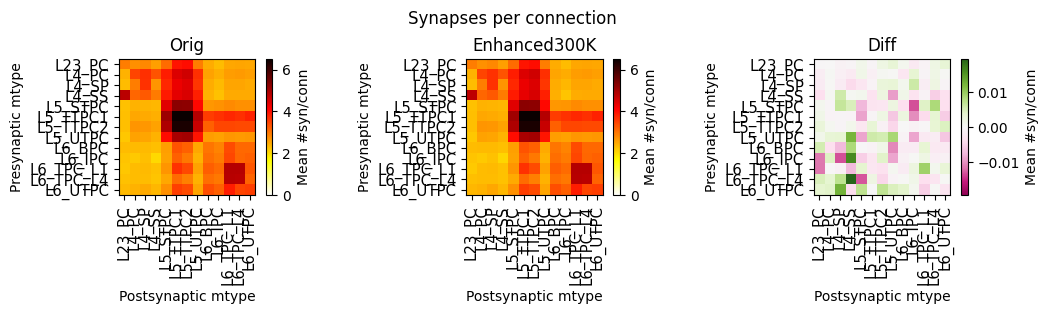

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced300K/struct_comp-ConnPerMtype_mc2EE-conn_prob.png...


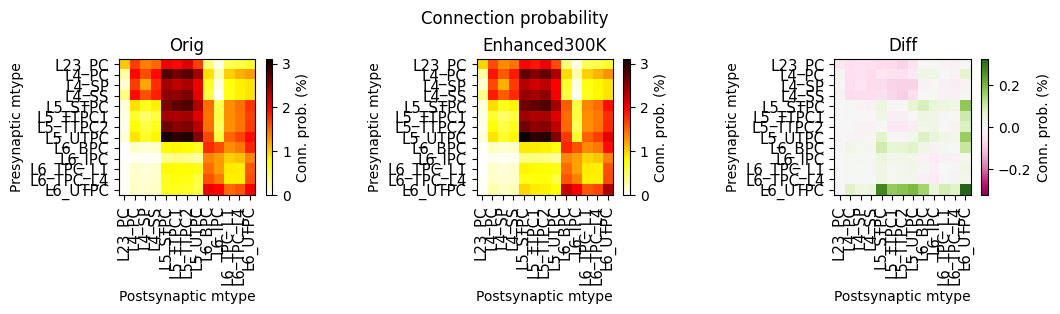

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireEnhanced400Kmc2EE/circuit_config.json
INFO: Preparing "ConnPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerLayer_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced400K_ConnPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced400K/struct_comp-ConnPerLayer_mc2EE-nsyn_conn.png...


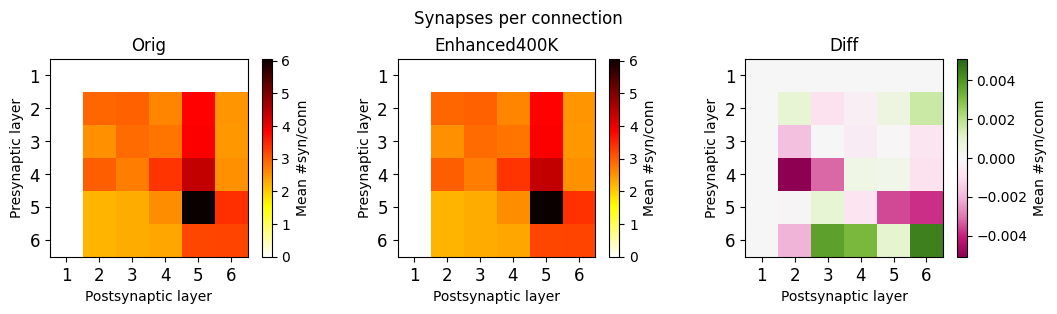

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced400K/struct_comp-ConnPerLayer_mc2EE-conn_prob.png...


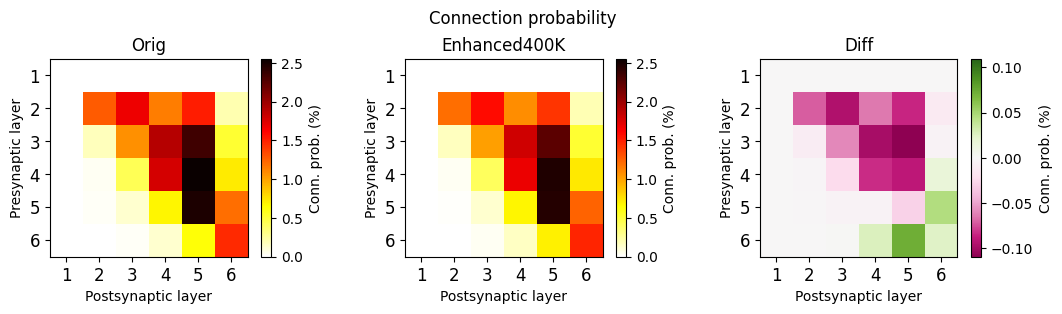

INFO: Preparing "ConnPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerMtype_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced400K_ConnPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced400K/struct_comp-ConnPerMtype_mc2EE-nsyn_conn.png...


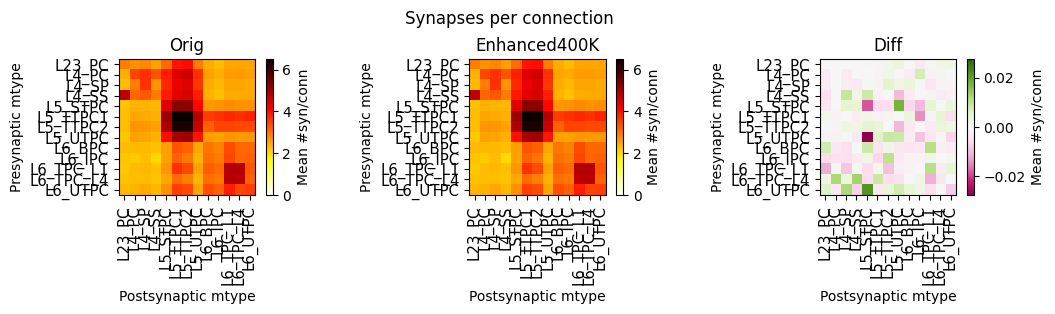

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced400K/struct_comp-ConnPerMtype_mc2EE-conn_prob.png...


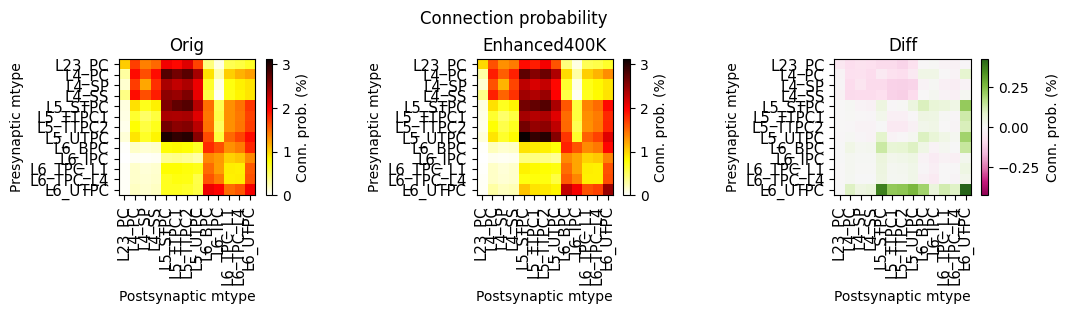

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireEnhanced500Kmc2EE/circuit_config.json
INFO: Preparing "ConnPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerLayer_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced500K_ConnPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced500K/struct_comp-ConnPerLayer_mc2EE-nsyn_conn.png...


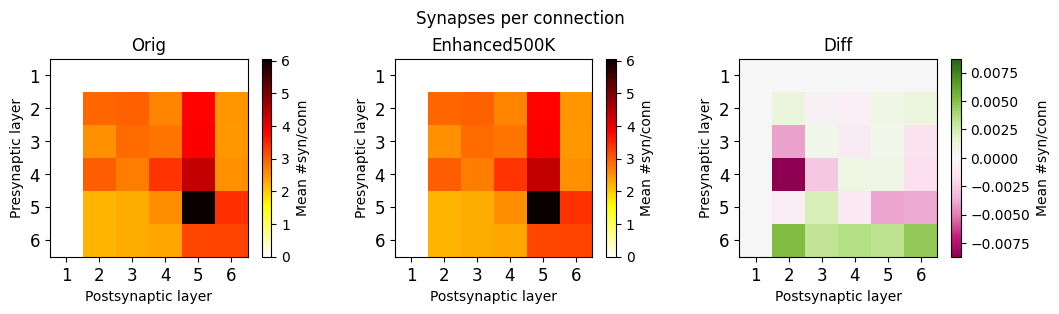

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced500K/struct_comp-ConnPerLayer_mc2EE-conn_prob.png...


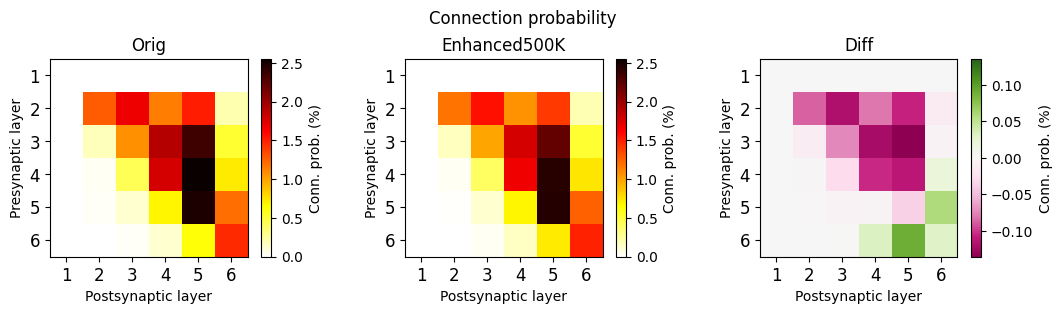

INFO: Preparing "ConnPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerMtype_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced500K_ConnPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced500K/struct_comp-ConnPerMtype_mc2EE-nsyn_conn.png...


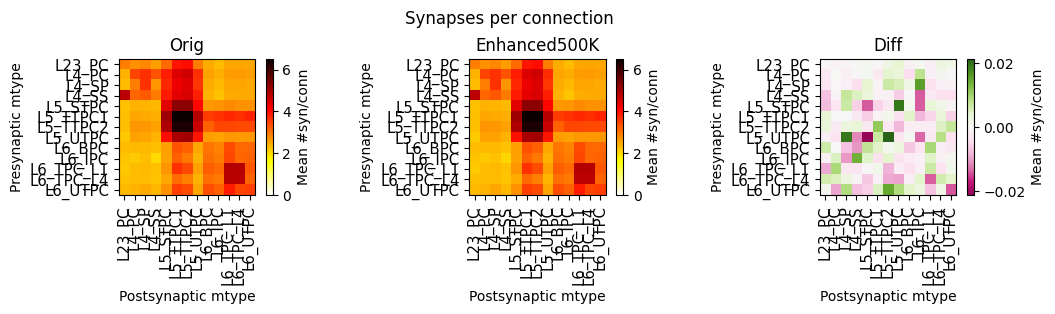

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced500K/struct_comp-ConnPerMtype_mc2EE-conn_prob.png...


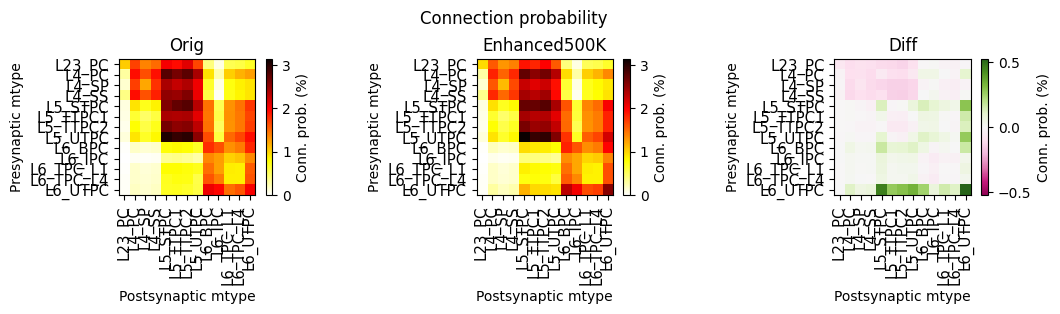

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA/sonata/circuit_config_tmp.json
  /gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA__ConnRewireEnhanced670Kmc2EE/circuit_config.json
INFO: Preparing "ConnPerLayer_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerLayer_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced670K_ConnPerLayer_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced670K/struct_comp-ConnPerLayer_mc2EE-nsyn_conn.png...


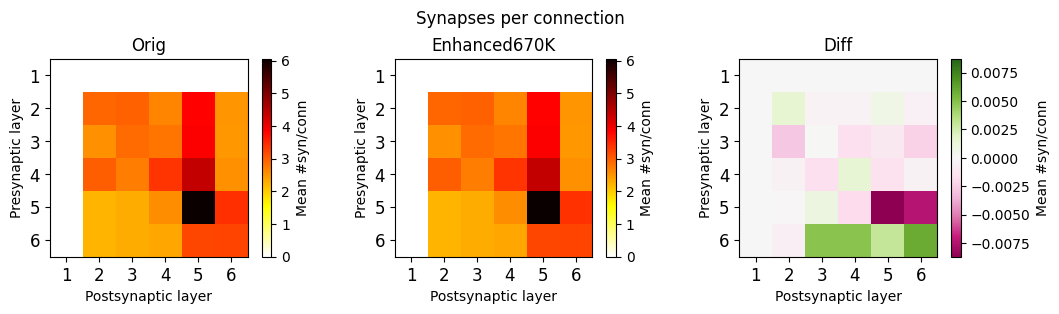

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced670K/struct_comp-ConnPerLayer_mc2EE-conn_prob.png...


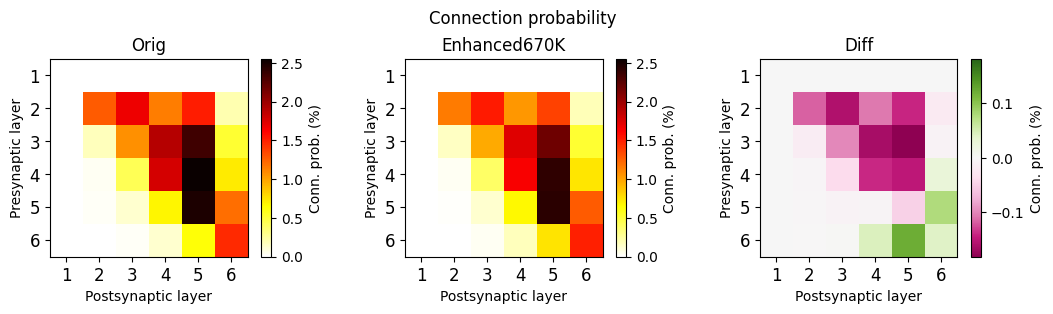

INFO: Preparing "ConnPerMtype_mc2EE" plot(s)...
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Orig_ConnPerMtype_mc2EE.pickle
INFO: Loading results from /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/data/Enhanced670K_ConnPerMtype_mc2EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced670K/struct_comp-ConnPerMtype_mc2EE-nsyn_conn.png...


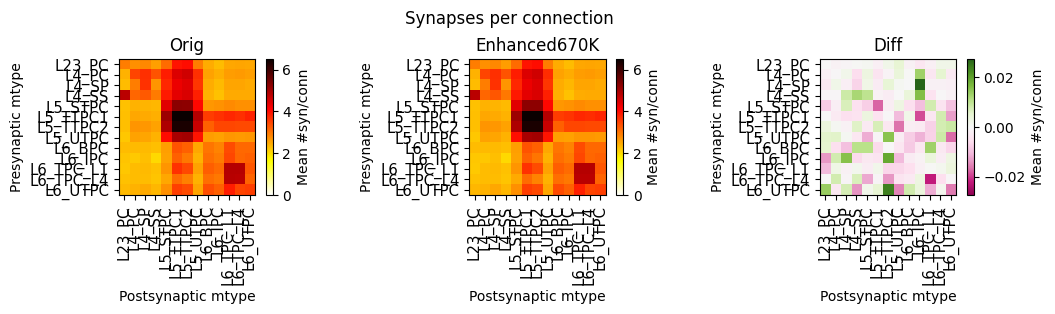

INFO: Saving /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/enhanced_connectivity/struct_comparison/O1v5-SONATA/Orig_vs_Enhanced670K/struct_comp-ConnPerMtype_mc2EE-conn_prob.png...


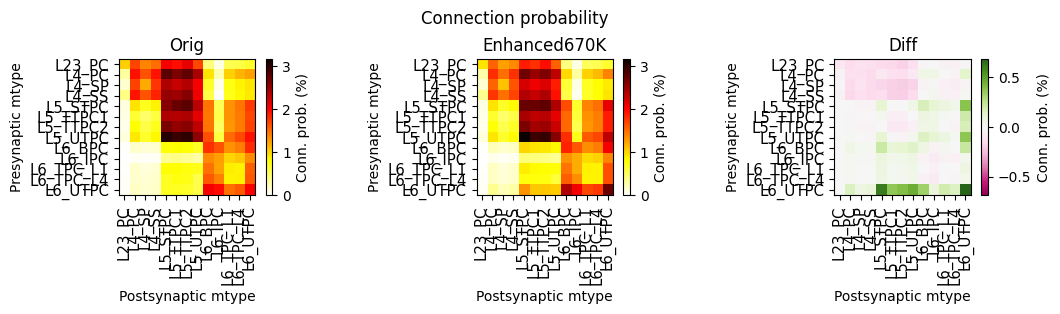

In [16]:
# Load config & run 1st-order comparison
for _n in enhance_N:
    structcomp_config = load_config_from_file(config_paths[-1], f'structcomp_config__{circuit_name_base}__Orig_vs_Enhanced{_n}K.json')
    structural_comparator.main(structcomp_config, show_fig=True, force_recomp=[False, False])